In [1]:
!pip install qiskit ipywidgets
!pip install pylatexenc
!pip install qiskit-aer
!pip install qiskit-ibm-runtime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=0776deb9fb5d3ae6a484f088ef944695474e91284d80c8e2baaa8d7eefaef161
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built py

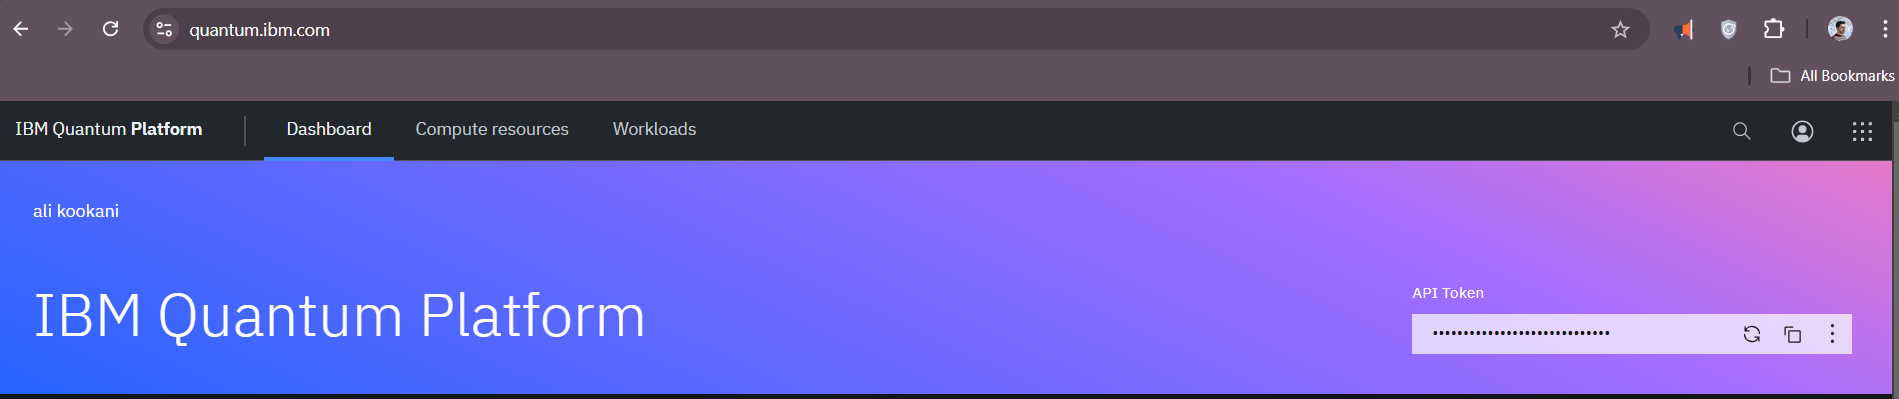

In [2]:
with open('token.txt', 'r') as file:
    my_token = file.read().strip()

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', token=my_token)

In [4]:
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2

In [9]:
backend_aer = AerSimulator(seed_simulator=42)
backend_ibm = service.get_backend('ibm_kyiv')

<ipython-input-9-9c817dfdfce5>:2: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend_ibm = service.get_backend('ibm_kyiv')


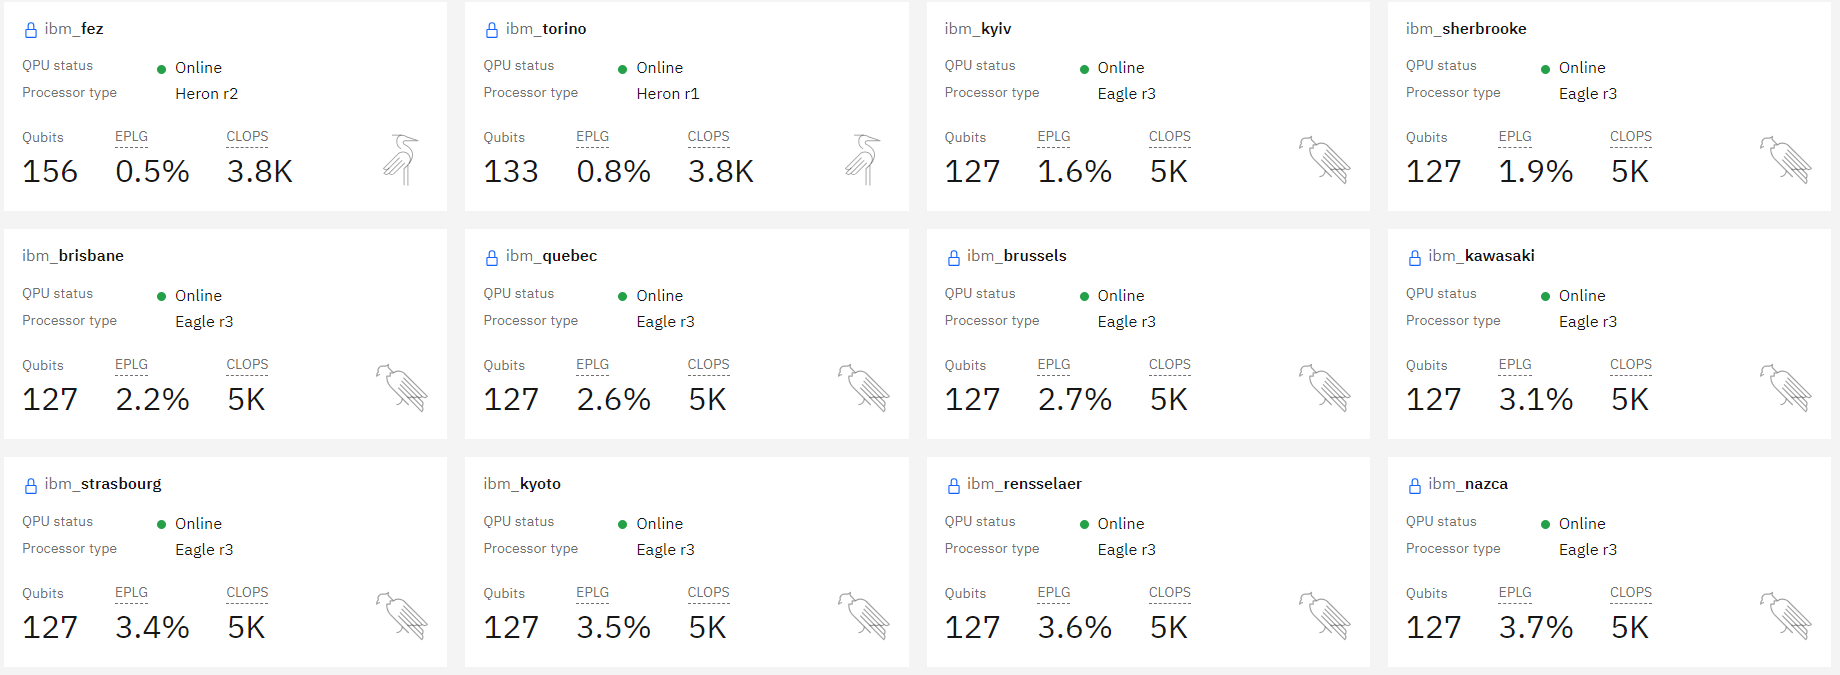

In [26]:
sampler_aer = SamplerV2(backend=backend_aer)
sampler_ibm = SamplerV2(backend=backend_ibm)

<ipython-input-26-7335f4caed4a>:1: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler_aer = SamplerV2(backend=backend_aer)
<ipython-input-26-7335f4caed4a>:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler_ibm = SamplerV2(backend=backend_ibm)


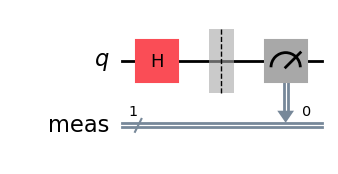

In [8]:
qc = QuantumCircuit(1)
qc.h(0)
qc.measure_all()
qc.draw('mpl')

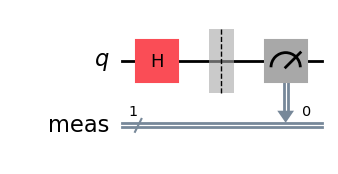

In [13]:
qc1_aer = transpile(qc, backend=backend_aer)
qc1_aer.draw('mpl')

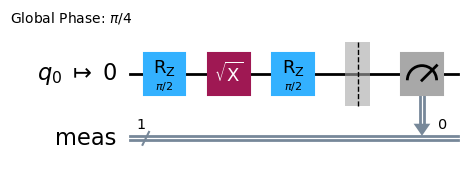

In [14]:
qc1_ibm = transpile(qc, backend=backend_ibm)
qc1_ibm.draw('mpl', idle_wires=False)

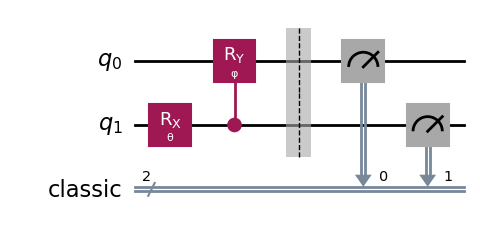

In [15]:
theta = Parameter('θ')
phi = Parameter('φ')

qr = QuantumRegister(2, name='q')
cr = ClassicalRegister(2, name='classic')
qc2 = QuantumCircuit(qr, cr)
qc2.rx(theta, 1)
qc2.cry(phi, 1, 0)
qc2.barrier()
qc2.measure(qr, cr)
qc2.draw('mpl')

In [16]:
print(qc2.parameters)

ParameterView([Parameter(θ), Parameter(φ)])


In [18]:
angles = [[pi/4, pi/2], [pi/3, pi], [pi/2, 2*pi]]

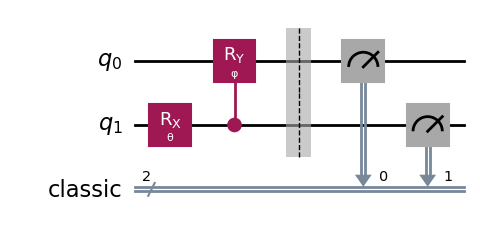

In [20]:
qc2_aer = transpile(qc2, backend=backend_aer)
qc2_aer.draw('mpl')

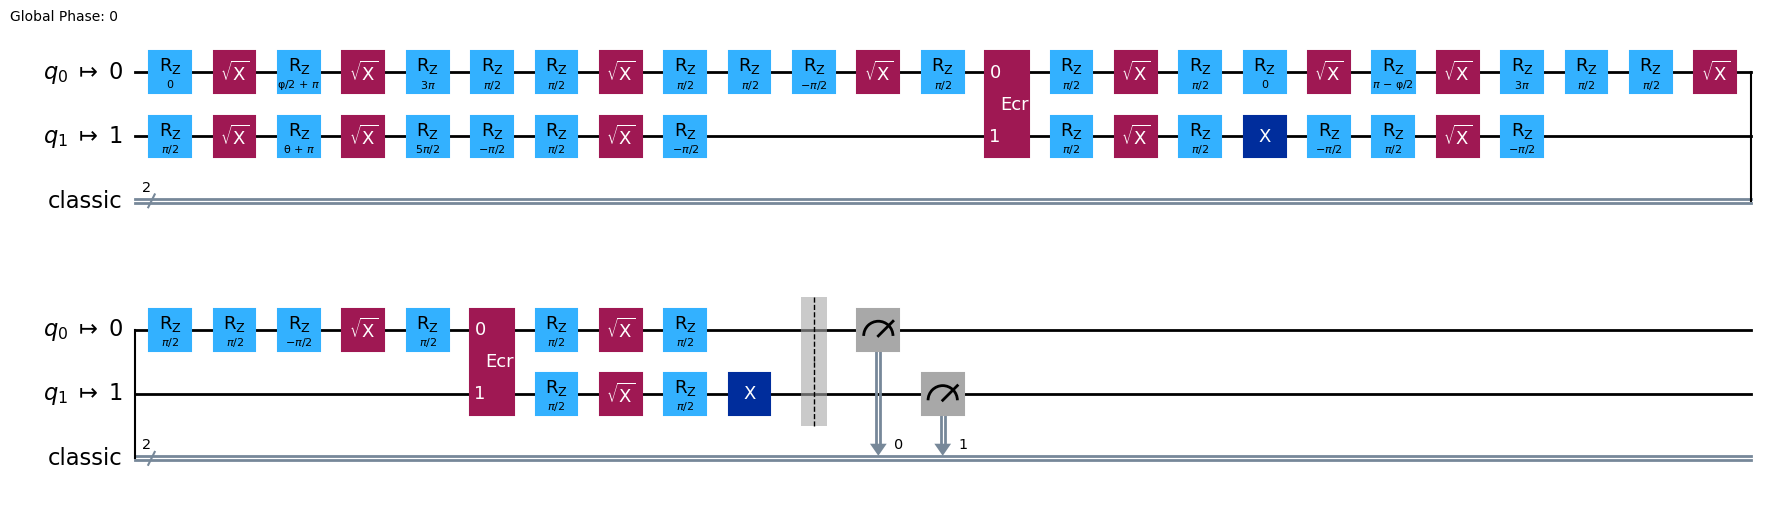

In [22]:
qc2_ibm = transpile(qc2, backend=backend_ibm, optimization_level=0)
qc2_ibm.draw('mpl', idle_wires=False)

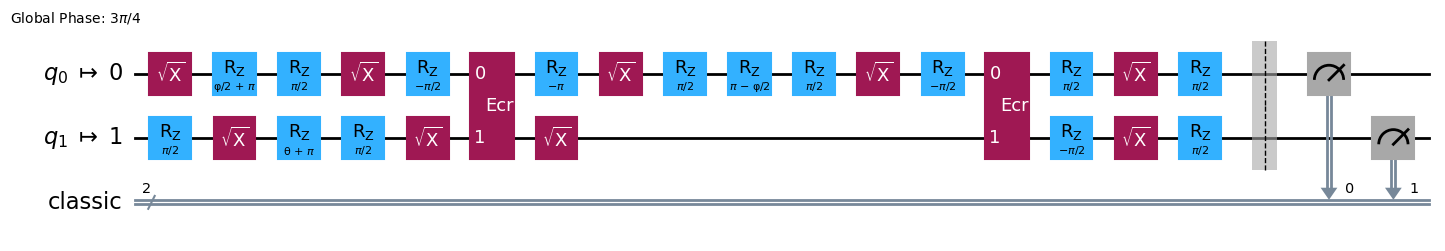

In [23]:
qc2_ibm = transpile(qc2, backend=backend_ibm, optimization_level=1)
qc2_ibm.draw('mpl', idle_wires=False)

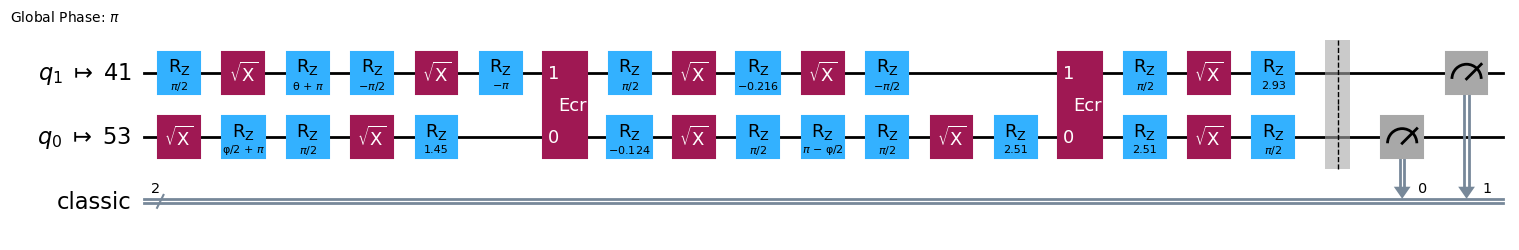

In [24]:
qc2_ibm = transpile(qc2, backend=backend_ibm, optimization_level=3)
qc2_ibm.draw('mpl', idle_wires=False)

In [32]:
result_aer = sampler_aer.run([(qc1_aer, None, 100), (qc2_aer, angles, 1000)]).result()
result_ibm = sampler_ibm.run([(qc1_ibm, None, 100), (qc2_ibm, angles, 1000)]).result()


In [45]:
counts_qc1_aer = result_aer[0].data.meas.get_counts()
counts_qc1_ibm = result_ibm[0].data.meas.get_counts()

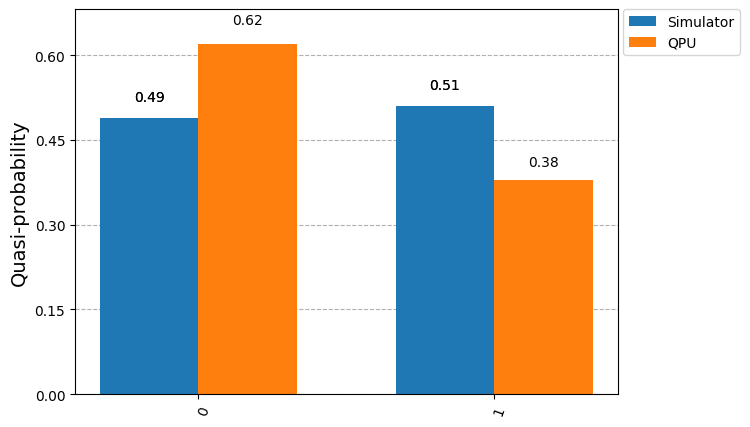

In [34]:
plot_distribution([counts_qc1_aer, counts_qc1_ibm], legend=['Simulator', 'QPU'])

In [37]:
counts_qc2_aer = result_aer[1].data.classic.get_counts()
counts_qc2_ibm = result_ibm[1].data.classic.get_counts()

In [38]:
print(f'Aer: {counts_qc2_aer}')
print(f'IBM: {counts_qc2_ibm}')

Aer: {'00': 2123, '10': 565, '11': 312}
IBM: {'00': 2054, '11': 342, '10': 598, '01': 6}


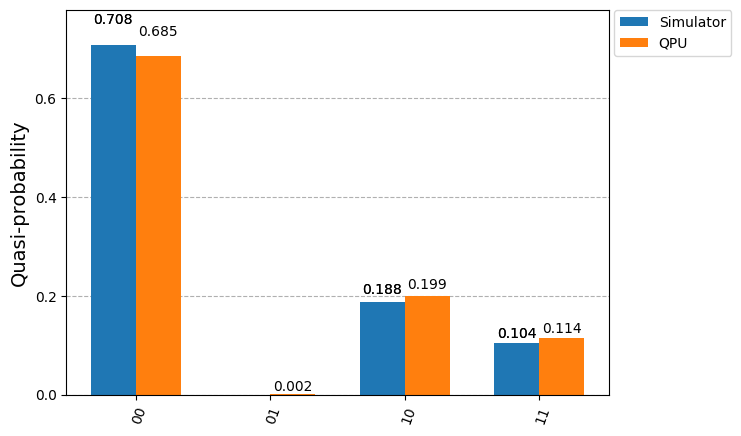

In [39]:
plot_distribution([counts_qc2_aer, counts_qc2_ibm], legend=['Simulator', 'QPU'])

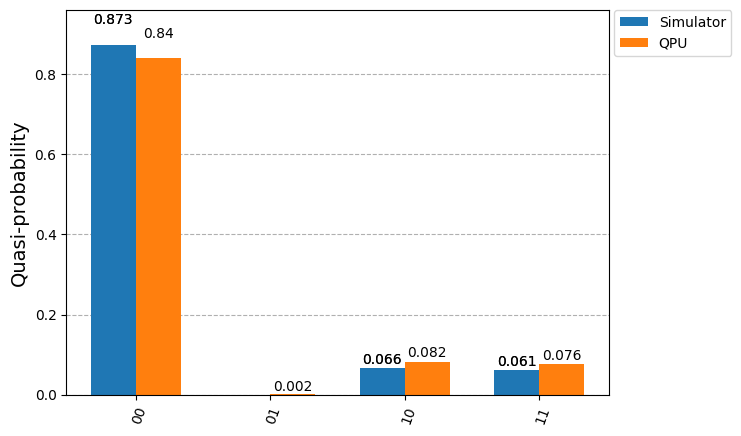

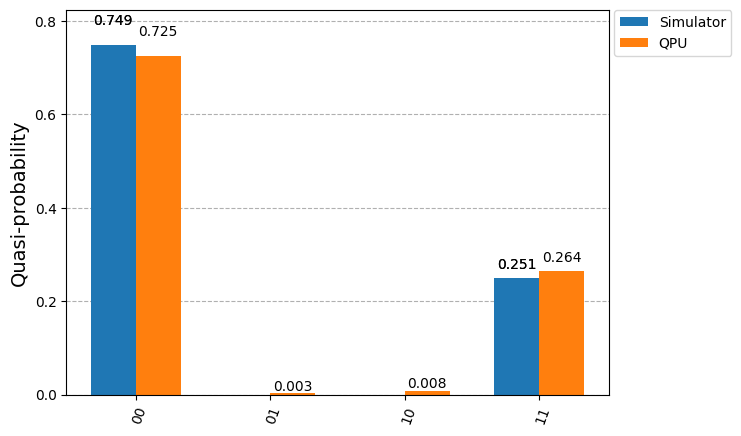

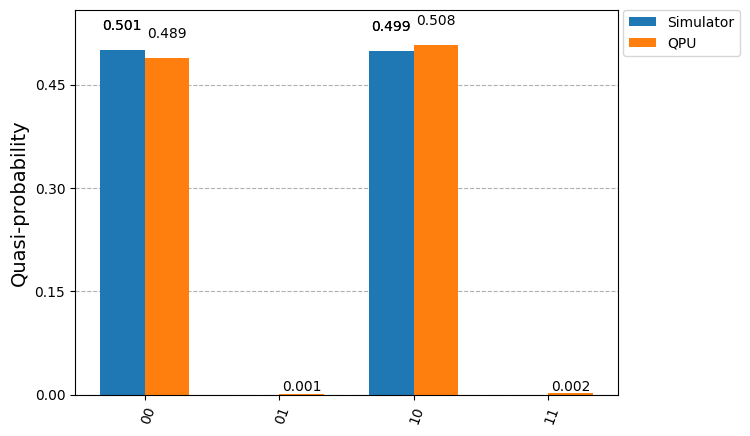

In [41]:
for i in range(len(angles)):
    counts_qc2_aer = result_aer[1].data.classic.get_counts(i)
    counts_qc2_ibm = result_ibm[1].data.classic.get_counts(i)
    display(plot_distribution([counts_qc2_aer, counts_qc2_ibm], legend=['Simulator', 'QPU']))

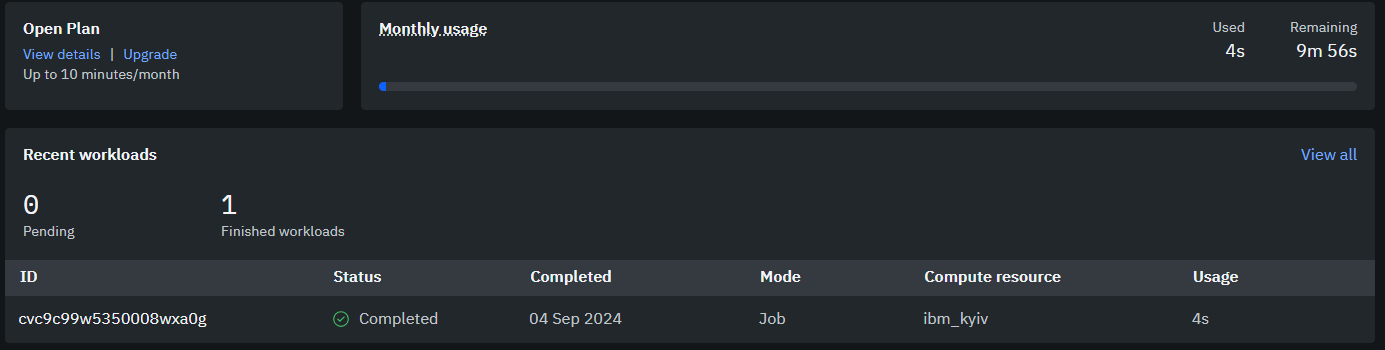

In [43]:
service.save_account(my_token, channel='ibm_quantum')
job_saved = QiskitRuntimeService().job('cvms54cqwj7g008y4hg0')
saved_result = job_saved.result()

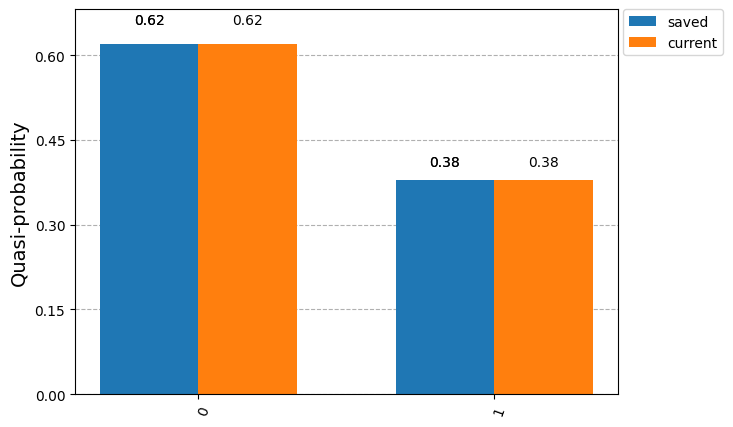

In [46]:
saved_counts_qc1 = saved_result[0].data.meas.get_counts()
display(plot_distribution([saved_counts_qc1, counts_qc1_ibm], legend=['saved', 'current']))

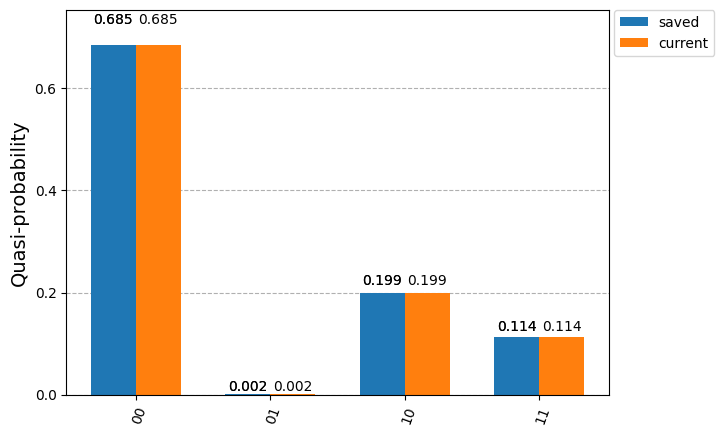

In [49]:
saved_counts_qc2 = saved_result[1].data.classic.get_counts()
counts_qc2_ibm = result_ibm[1].data.classic.get_counts()
display(plot_distribution([saved_counts_qc2, counts_qc2_ibm], legend=['saved', 'current']))

saved: {'00': 840, '11': 76, '10': 82, '01': 2}
current: {'00': 840, '11': 76, '10': 82, '01': 2}


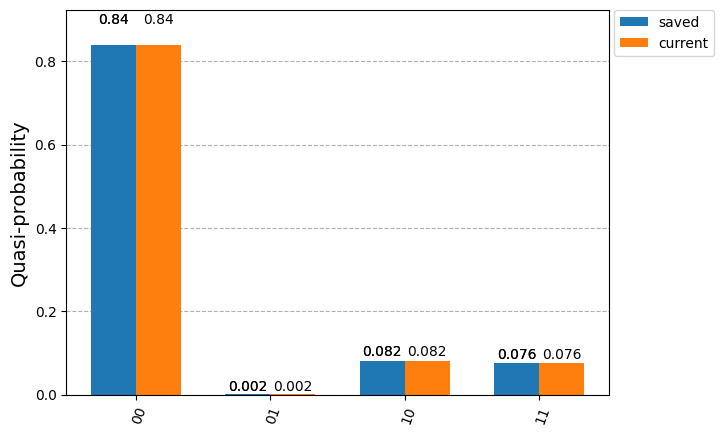

saved: {'00': 725, '11': 264, '01': 3, '10': 8}
current: {'00': 725, '11': 264, '01': 3, '10': 8}


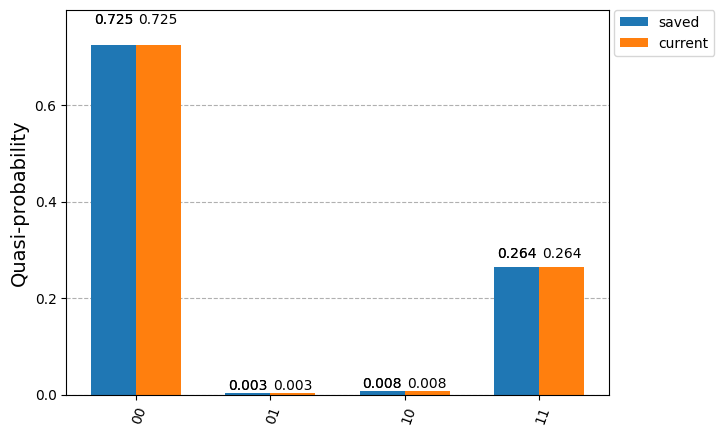

saved: {'10': 508, '00': 489, '11': 2, '01': 1}
current: {'10': 508, '00': 489, '11': 2, '01': 1}


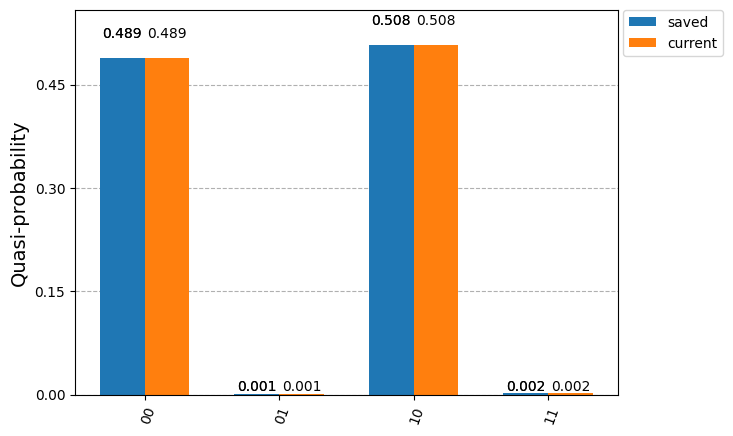

In [50]:
for i in range(len(angles)):
    counts_qc2_saved = saved_result[1].data.classic.get_counts(i)
    counts_qc2_ibm = result_ibm[1].data.classic.get_counts(i)
    print(f'saved: {counts_qc2_saved}')
    print(f'current: {counts_qc2_ibm}')
    display(plot_distribution([counts_qc2_saved, counts_qc2_ibm], legend=['saved', 'current']))

In [51]:
estimator_aer = EstimatorV2(backend=backend_aer)
estimator_ibm = EstimatorV2(backend=backend_ibm)

<ipython-input-51-b1a79dd3e9d5>:1: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator_aer = EstimatorV2(backend=backend_aer)
<ipython-input-51-b1a79dd3e9d5>:2: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator_ibm = EstimatorV2(backend=backend_ibm)


In [53]:
obsv_list = [[SparsePauliOp(['XX', 'IY'], [0.5, 0.5])],
             [SparsePauliOp(['XX'], [1])],
             [SparsePauliOp(['IY'], [1])]
             ]

In [54]:
layout = qc2_ibm.layout
layout

TranspileLayout(initial_layout=Layout({
41: Qubit(QuantumRegister(2, 'q'), 1),
53: Qubit(QuantumRegister(2, 'q'), 0),
0: Qubit(QuantumRegister(125, 'ancilla'), 0),
1: Qubit(QuantumRegister(125, 'ancilla'), 1),
2: Qubit(QuantumRegister(125, 'ancilla'), 2),
3: Qubit(QuantumRegister(125, 'ancilla'), 3),
4: Qubit(QuantumRegister(125, 'ancilla'), 4),
5: Qubit(QuantumRegister(125, 'ancilla'), 5),
6: Qubit(QuantumRegister(125, 'ancilla'), 6),
7: Qubit(QuantumRegister(125, 'ancilla'), 7),
8: Qubit(QuantumRegister(125, 'ancilla'), 8),
9: Qubit(QuantumRegister(125, 'ancilla'), 9),
10: Qubit(QuantumRegister(125, 'ancilla'), 10),
11: Qubit(QuantumRegister(125, 'ancilla'), 11),
12: Qubit(QuantumRegister(125, 'ancilla'), 12),
13: Qubit(QuantumRegister(125, 'ancilla'), 13),
14: Qubit(QuantumRegister(125, 'ancilla'), 14),
15: Qubit(QuantumRegister(125, 'ancilla'), 15),
16: Qubit(QuantumRegister(125, 'ancilla'), 16),
17: Qubit(QuantumRegister(125, 'ancilla'), 17),
18: Qubit(QuantumRegister(125, 'ancill

In [55]:
obsv_ibm = []
for obsv in obsv_list:
  obsv_t = obsv[0].apply_layout(layout)
  print(obsv_t)
  obsv_ibm.append([obsv_t])

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIIIIIIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


In [58]:
exp_vals_aer = estimator_aer.run([(qc2_aer, obsv_list, angles, 0.01)]).result()
exp_vals_ibm = estimator_ibm.run([(qc2_ibm, obsv_ibm, angles, 0.01)]).result()

In [60]:
exp_vals_aer1 = exp_vals_aer[0].data.evs
exp_vals_ibm1 = exp_vals_ibm[0].data.evs

In [61]:
print(f"Expection values of Aer: \n{exp_vals_aer1}")
print(f"Expection values of IBM: \n{exp_vals_ibm1}")

Expection values of Aer: 
[[ 0.0011  0.0173  0.0174]
 [-0.004   0.0014 -0.0018]
 [ 0.0062  0.0332  0.0366]]
Expection values of IBM: 
[[-0.02367214  0.00953157  0.01498382]
 [-0.02319393  0.01342807 -0.02034556]
 [-0.02415034  0.00563508  0.0503132 ]]
